In [2]:
pip install torchvision


  Obtaining dependency information for torchvision from https://files.pythonhosted.org/packages/13/24/23cdf7e7dc33e5c01588c315f8424d31afa9edb05a80168f3d44f7178ff7/torchvision-0.16.1-cp311-cp311-win_amd64.whl.metadata
   ---------------------------------------- 0.0/1.1 MB ? eta -:--:--
   ---------------------------------------- 0.0/1.1 MB ? eta -:--:--
   ---------------------------------------- 0.0/1.1 MB ? eta -:--:--
   ---------------------------------------- 0.0/1.1 MB ? eta -:--:--
   ---------------------------------------- 0.0/1.1 MB ? eta -:--:--
   - -------------------------------------- 0.0/1.1 MB 2.0 MB/s eta 0:00:01
   - -------------------------------------- 0.0/1.1 MB 2.0 MB/s eta 0:00:01
   - -------------------------------------- 0.0/1.1 MB 2.0 MB/s eta 0:00:01
   ---- ----------------------------------- 0.1/1.1 MB 516.7 kB/s eta 0:00:02
   ---- ----------------------------------- 0.1/1.1 MB 516.7 kB/s eta 0:00:02
   ---- ----------------------------------- 0.1/1.1 M

In [4]:
pip install segmentation-models-pytorch


  Obtaining dependency information for segmentation-models-pytorch from https://files.pythonhosted.org/packages/cb/70/4aac1b240b399b108ce58029ae54bc14497e1bbc275dfab8fd3c84c1e35d/segmentation_models_pytorch-0.3.3-py3-none-any.whl.metadata
     ---------------------------------------- 0.0/58.8 kB ? eta -:--:--
     ------ --------------------------------- 10.2/58.8 kB ? eta -:--:--
     ------ --------------------------------- 10.2/58.8 kB ? eta -:--:--
     ------ --------------------------------- 10.2/58.8 kB ? eta -:--:--
     ------ --------------------------------- 10.2/58.8 kB ? eta -:--:--
     -------------------------------------- 58.8/58.8 kB 258.4 kB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Obtaining dependency information for timm==0.9.2 from https://files.pythonhosted.org/packages/29/90/94f5deb8d7

In [5]:
import os
import torch
import torchvision
from torchvision import models
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from sklearn.model_selection import train_test_split
import segmentation_models_pytorch as smp
import numpy as np
import pandas as pd

from PIL import Image

import numpy as np
import matplotlib.pyplot as plt
import os
import random

In [6]:
#Data images: "C:\Users\HP\OneDrive\Desktop\ChiSquareDatasets(Images)\data_images"
#Annoted images: "C:\Users\HP\OneDrive\Desktop\ChiSquareDatasets(Images)\annotated_images"

In [7]:
# Function for loading images 

def load_images_as_numpy(folder_path, limit=None):
    image_list = []
    count = 0
    for filename in os.listdir(folder_path):
        if filename.endswith(".png"):
            image_path = os.path.join(folder_path, filename)
            img = Image.open(image_path)
            img = img.resize((256,256))  
            img = img.convert("RGB")  
            img_array = np.array(img)
            image_list.append(img_array)
            count += 1
            if limit is not None and count >= limit:
                break
    return np.stack(image_list)

# link your dataset folder here 
frames_folder = r'C:\Users\HP\OneDrive\Desktop\ChiSquareDatasets(Images)\data_images'  
masks_folder = r'C:\Users\HP\OneDrive\Desktop\ChiSquareDatasets(Images)\annotated_images'
limit = 127  
frames_array = load_images_as_numpy(frames_folder, limit=limit)
masks_array = load_images_as_numpy(masks_folder, limit=limit)

print("Frames shape:", frames_array.shape)
print("Masks shape:", masks_array.shape)

Frames shape: (127, 256, 256, 3)
Masks shape: (127, 256, 256, 3)


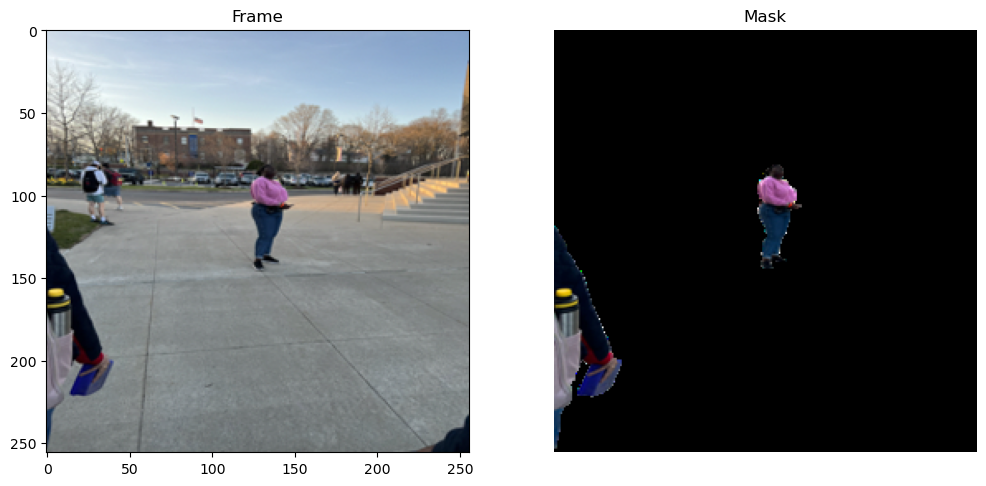

In [8]:
import matplotlib.pyplot as plt

index_to_visualize = 0

# Create subplots with 1 row and 2 columns
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Plot the frame
plt.axis('off')
axs[0].imshow(frames_array[index_to_visualize])

axs[0].set_title('Frame')

# Plot the mask
plt.axis('off')
axs[1].imshow(masks_array[index_to_visualize], cmap='gray')
plt.axis('off')
axs[1].set_title('Mask')

plt.show()

In [9]:
def process_masks(masks_array):
    averaged_array = np.mean(masks_array, axis=-1, keepdims=True)  
    new_masks_array = np.where(averaged_array > 0, 1, 0)  
    return new_masks_array

processed_masks = process_masks(masks_array)

In [10]:
processed_masks.shape

(127, 256, 256, 1)

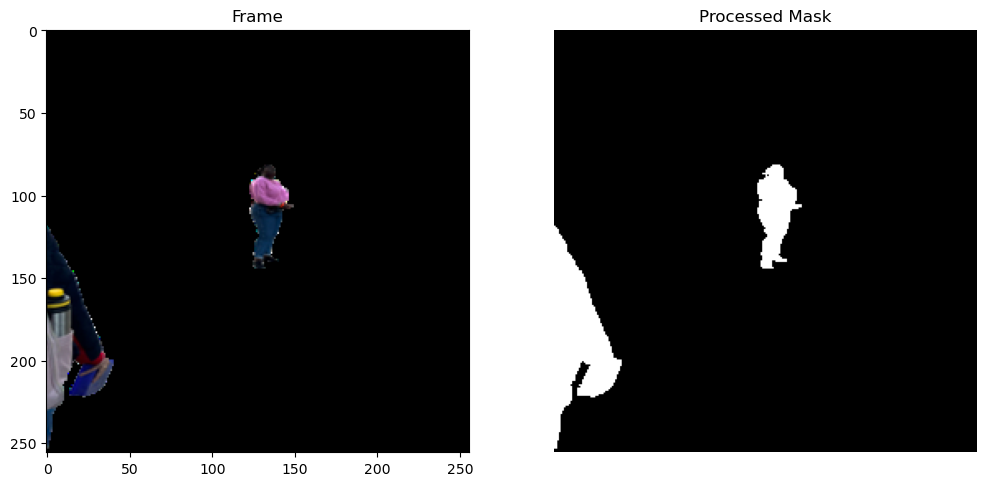

In [11]:
import matplotlib.pyplot as plt

index_to_visualize = 0

# Create subplots with 1 row and 2 columns
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
plt.axis('off')

axs[0].imshow(masks_array[index_to_visualize])

axs[0].set_title('Frame')

# Plot the mask

axs[1].imshow(processed_masks[index_to_visualize], cmap='gray')

axs[1].set_title('Processed Mask')

plt.show()

In [13]:
import torch
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, TensorDataset

from segmentation_models_pytorch import Unet
import segmentation_models_pytorch as smp


frames_tensor = torch.tensor(frames_array, dtype=torch.float32).permute(0, 3, 1, 2)  # Assuming channels are in the last dimension
masks_tensor = torch.tensor(processed_masks, dtype=torch.float32).permute(0, 3, 1, 2)


frames_tensor /= 255.0


dataset = TensorDataset(frames_tensor, masks_tensor)


train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])


train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

Epoch [1/8] - Train Loss: 0.5104 - Test Loss: 12.7599 - Elapsed Time: 106.33 seconds
Epoch [2/8] - Train Loss: 0.3057 - Test Loss: 0.8103 - Elapsed Time: 83.62 seconds
Epoch [3/8] - Train Loss: 0.2281 - Test Loss: 0.2608 - Elapsed Time: 84.63 seconds
Epoch [4/8] - Train Loss: 0.1675 - Test Loss: 0.1765 - Elapsed Time: 85.85 seconds
Epoch [5/8] - Train Loss: 0.1332 - Test Loss: 0.1610 - Elapsed Time: 120.33 seconds
Epoch [6/8] - Train Loss: 0.1154 - Test Loss: 0.1482 - Elapsed Time: 83.96 seconds
Epoch [7/8] - Train Loss: 0.0987 - Test Loss: 0.1533 - Elapsed Time: 86.05 seconds
Epoch [8/8] - Train Loss: 0.0861 - Test Loss: 0.1361 - Elapsed Time: 71.99 seconds
Total training time: -1701694072.739 seconds


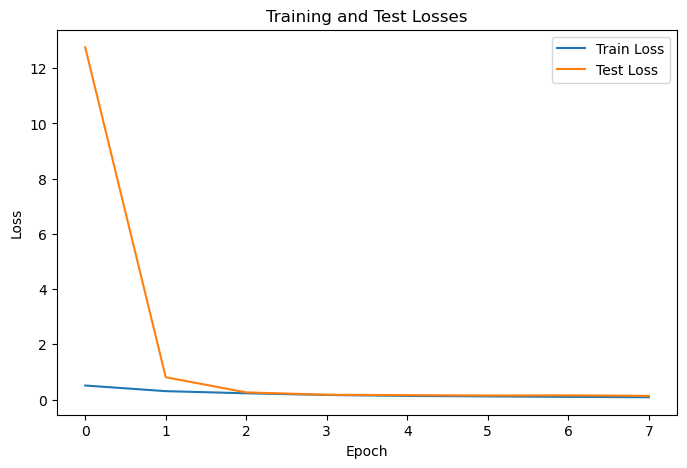

In [29]:
import matplotlib.pyplot as plt
import time


from timeit import default_timer as timer 
# Assuming train_loader and test_loader are defined

torch.manual_seed(42) 
torch.cuda.manual_seed(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = smp.Unet(encoder_name="resnet34", encoder_weights='imagenet', in_channels=3, classes=1) 

criterion = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

num_epochs = 8

model.to(device)

train_losses = []  
test_losses = []  

start_time = timer()



for epoch in range(num_epochs):
    model.train()
    epoch_train_losses = []  
    epoch_test_losses = []  

    start_time = time.time()

    # Training loop
    for frames, masks in train_loader:
        frames, masks = frames.to(device), masks.to(device)

        optimizer.zero_grad()
        outputs = model(frames)
        loss = criterion(outputs, masks)
        epoch_train_losses.append(loss.item()) 
        loss.backward()
        optimizer.step()

    epoch_train_loss = sum(epoch_train_losses) / len(epoch_train_losses)
    train_losses.append(epoch_train_loss)

    model.eval()
    with torch.no_grad():
        # Testing loop
        for frames, masks in test_loader:
            frames, masks = frames.to(device), masks.to(device)
            outputs = model(frames)

            test_loss = criterion(outputs, masks)
            epoch_test_losses.append(test_loss.item())

    epoch_test_loss = sum(epoch_test_losses) / len(epoch_test_losses)
    test_losses.append(epoch_test_loss)

    elapsed_time = time.time() - start_time
    print(f"Epoch [{epoch+1}/{num_epochs}] - Train Loss: {epoch_train_loss:.4f} - Test Loss: {epoch_test_loss:.4f} - Elapsed Time: {elapsed_time:.2f} seconds")

    
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

# Plotting the losses
plt.figure(figsize=(8, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test Losses')
plt.legend()
plt.show()

(127, 256, 256, 3)
torch.Size([127, 3, 256, 256])


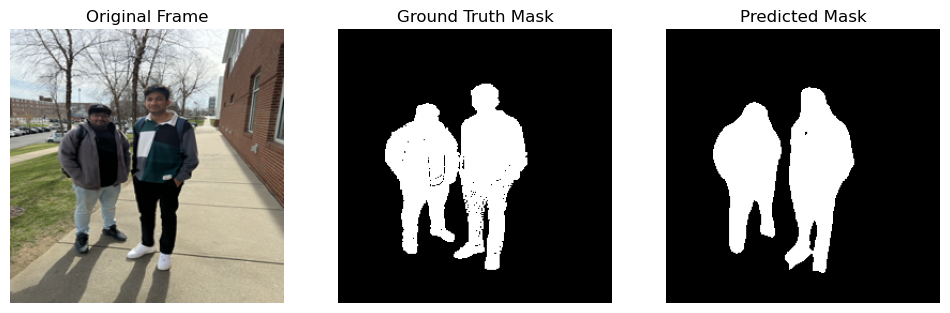

In [30]:
import torch
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


def process_masks2(masks_array):
    new_masks_array = np.where(masks_array > 0, 1, 0)
    return new_masks_array


print(frames_array.shape)

frames_tensor = torch.tensor(frames_array, dtype=torch.float32).permute(0, 3, 1, 2)  # Assuming channels are in the last dimension


frames_tensor /= 255.0


frames_tensor = frames_tensor.to(device)


model.eval()


with torch.no_grad():
    predictions = model(frames_tensor)
    print(frames_tensor.shape)
    

predictions_np = predictions.cpu().numpy()

predictions_np =  process_masks2(predictions_np)




plt.figure(figsize=(12, 6))

        # Plot the original frame
plt.subplot(1, 3, 1)
plt.axis('off')
plt.imshow(frames_array[8])
plt.title("Original Frame")

        # Plot the ground truth mask
plt.subplot(1, 3, 2)
plt.imshow(processed_masks[8, ..., 0], cmap="gray")  # Assuming masks are grayscale
plt.axis('off')
plt.title("Ground Truth Mask")

        # Plot the predicted mask
plt.subplot(1, 3, 3)
plt.imshow(predictions_np[8, 0], cmap="gray")
plt.axis('off')
plt.title("Predicted Mask")
plt.show()

Text(0.5, 1.0, 'Predicted Mask')

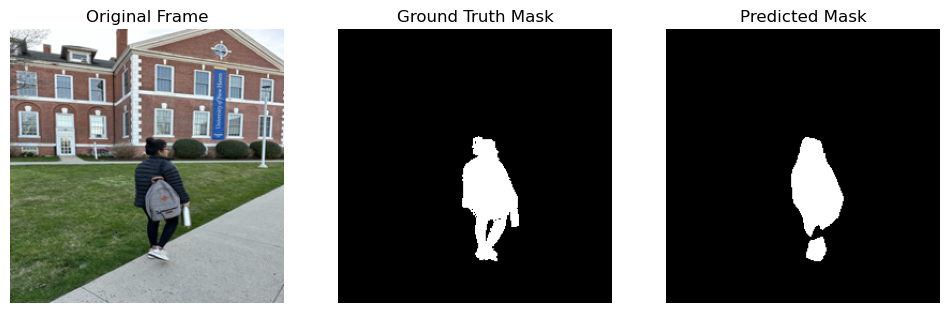

In [33]:
plt.figure(figsize=(12,6))

        # Plot the original frame
plt.subplot(1, 3, 1)
plt.axis('off')
plt.imshow(frames_array[102])
plt.title("Original Frame")

        # Plot the ground truth mask
plt.subplot(1, 3, 2)
plt.axis('off')
plt.imshow(processed_masks[102, ..., 0], cmap="gray")  # Assuming masks are grayscale
plt.title("Ground Truth Mask")

        # Plot the predicted mask
plt.subplot(1, 3, 3)
plt.axis('off')
plt.imshow(predictions_np[102, 0], cmap="gray")
plt.title("Predicted Mask")
# plt.show()

Text(0.5, 1.0, 'Predicted Mask')

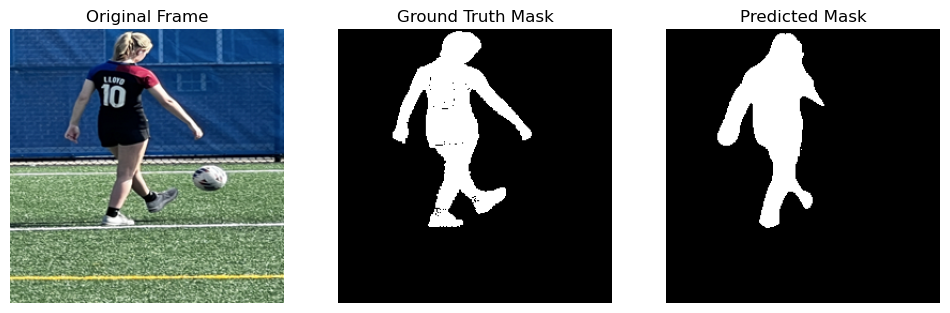

In [34]:
plt.figure(figsize=(12,6))

        # Plot the original frame
plt.subplot(1, 3, 1)
plt.imshow(frames_array[82])
plt.axis('off')
plt.title("Original Frame")

        # Plot the ground truth mask
plt.subplot(1, 3, 2)
plt.axis('off')
plt.imshow(processed_masks[82, ..., 0], cmap="gray")  # Assuming masks are grayscale
plt.title("Ground Truth Mask")

        # Plot the predicted mask
plt.subplot(1, 3, 3)
plt.axis('off')
plt.imshow(predictions_np[82,0], cmap="gray")
plt.title("Predicted Mask")
# plt.show()

In [35]:
# import numpy as np
def dice_coefficient(predictions, targets):
    intersection = np.sum(predictions * targets)
    union = np.sum(predictions) + np.sum(targets)
    return (2.0 * intersection) / (union + intersection + 1e-8)  # Adding a small constant to avoid division by zero


# Threshold predictions (assuming binary masks with values between 0 and 1)
threshold = 0.5
binary_predictions = (predictions_np > threshold).astype(np.float32)

# Calculate Dice scores for each pair of masks
dice_scores = []
for i in range(binary_predictions.shape[0]):
    for channel in range(masks_array.shape[-1]):
        dice = dice_coefficient(binary_predictions[i, 0, :, :], masks_array[i, :, :, channel])
        dice_scores.append(dice)

# Calculate the average Dice score
average_dice_score = np.mean(dice_scores)
print("Average Dice Score:", average_dice_score)

Average Dice Score: 0.8789949414396341


In [36]:
predictions_np1 = np.transpose(predictions_np, (0, 2, 3, 1))

In [37]:
final_predictions = predictions_np1 * frames_array

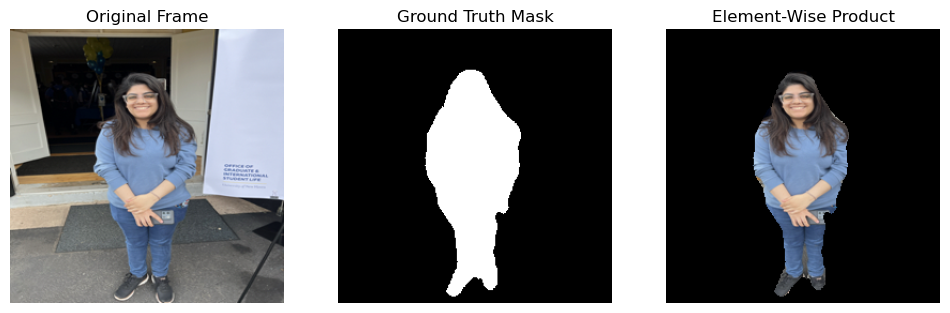

In [22]:
plt.figure(figsize=(12,6))

plt.subplot(1, 3, 1)
plt.axis('off')
plt.imshow(frames_array[9])
plt.title("Original Frame")

        # Plot the ground truth mask
plt.subplot(1, 3, 2)
plt.axis('off')
plt.imshow(predictions_np[9,0], cmap="gray")  # Assuming masks are grayscale
plt.title("Ground Truth Mask")

        # Plot the predicted mask
plt.subplot(1, 3, 3)
plt.axis('off')
plt.imshow(final_predictions[9], cmap="gray")
plt.title("Element-Wise Product")
plt.show()

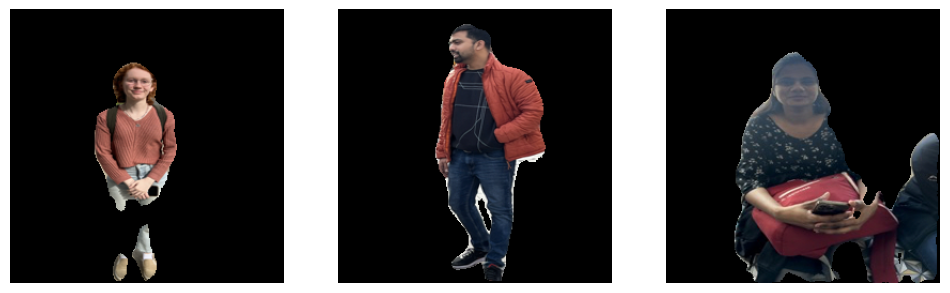

In [38]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 3, 1)
# plt.title("final prediction 1")
plt.imshow(final_predictions[12])
plt.axis('off')
plt.subplot(1, 3, 2)
# plt.title("final prediction 2")
plt.imshow(final_predictions[57])
plt.axis('off')
plt.subplot(1, 3, 3)
# plt.title("final prediction 3")
plt.imshow(final_predictions[119])
plt.axis('off')
plt.show()